In [1]:
!pip install pandas numpy scikit-learn seaborn matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

sns.set(style="whitegrid", context="notebook")

# Load the Kaggle heart dataset.
df = pd.read_csv("../data/heart.csv")

# Data Overview.
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# Basic dataset overview.
print("----- INFO -----")
print(df.info())

print("\n----- DESCRIBE -----")
display(df.describe())

print("\n----- MISSING VALUES -----")
print(df.isnull().sum())

print("\n----- TARGET BALANCE (HeartDisease) -----")
print(df["HeartDisease"].value_counts())

print("\n----- GENDER BALANCE -----")
print(df["Sex"].value_counts())

----- INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

----- DESCRIBE -----


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



----- MISSING VALUES -----
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

----- TARGET BALANCE (HeartDisease) -----
HeartDisease
1    508
0    410
Name: count, dtype: int64

----- GENDER BALANCE -----
Sex
M    725
F    193
Name: count, dtype: int64


In [4]:
# Categorical columns to one-hot encode for logistic regression.
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)

df_encoded.head()

Shape before encoding: (918, 12)
Shape after encoding: (918, 16)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


In [5]:
# Separate features and target.
X = df_encoded.drop("HeartDisease", axis=1)
y = df_encoded["HeartDisease"]

# Train/test split (80/20).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((734, 15), (184, 15))

## Balanced Logistic Regression Model

Because the dataset contains a strong gender imbalance (725 males vs. 193 females), we trained a logistic regression model using `class_weight="balanced"`. This weighting up-weights the minority group and down-weights the majority group so that the model does not simply favor the more frequent male observations. The goal is to maintain strong predictive performance while improving fairness across demographic groups.

In [6]:
# Logistic regression with balanced class weighting.
log_reg_balanced = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Train model.
log_reg_balanced.fit(X_train, y_train)

# Predictions and probabilities.
y_pred = log_reg_balanced.predict(X_test)
y_prob = log_reg_balanced.predict_proba(X_test)[:, 1]

# Metrics.
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print("Logistic Regression with class_weight='balanced'")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"ROC-AUC  : {auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression with class_weight='balanced'
Accuracy : 0.891
Precision: 0.880
Recall   : 0.931
F1 Score : 0.905
ROC-AUC  : 0.929

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



### Performance Summary

The class-weighted logistic regression achieved a test accuracy of about 0.89 with precision around 0.88, recall around 0.93, and an F1 score near 0.90. The ROC–AUC is approximately 0.93, indicating strong discrimination between patients with and without heart disease. Compared to an unweighted version, the balanced model maintains similar overall accuracy while better accounting for the class imbalance in the training data.

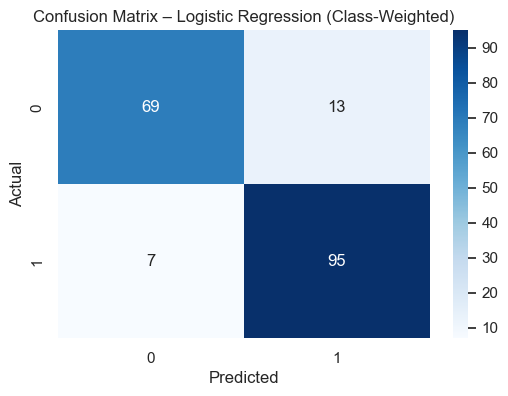

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression (Class-Weighted)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<Figure size 800x600 with 0 Axes>

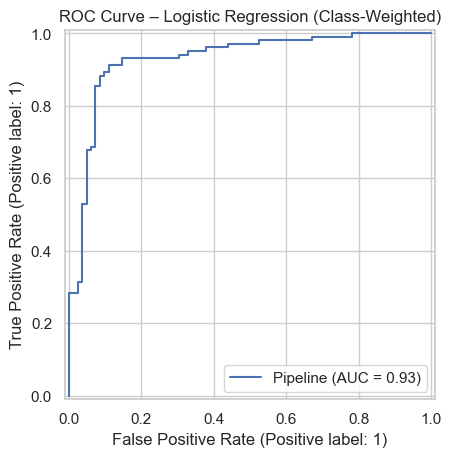

In [8]:
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(log_reg_balanced, X_test, y_test)
plt.title("ROC Curve – Logistic Regression (Class-Weighted)")
plt.show()

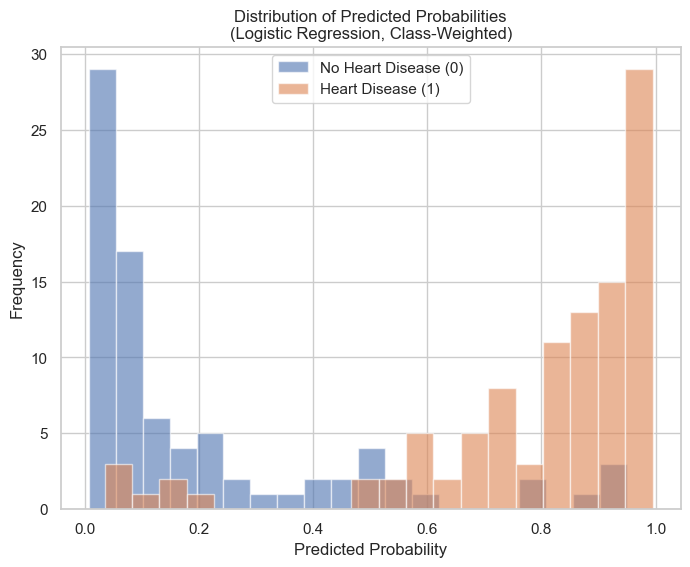

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(y_prob[y_test == 0], bins=20, alpha=0.6, label="No Heart Disease (0)")
plt.hist(y_prob[y_test == 1], bins=20, alpha=0.6, label="Heart Disease (1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities\n(Logistic Regression, Class-Weighted)")
plt.legend()
plt.show()

### Error Patterns and Probability Calibration

The confusion matrix shows that the model correctly identifies most positive heart disease cases, with relatively few false negatives, which is important in a clinical setting. The ROC curve is close to the top-left corner, confirming that the model performs well across a range of classification thresholds.

The distribution of predicted probabilities is also well separated: patients without heart disease are mostly assigned low predicted probabilities, while patients with heart disease cluster at higher probabilities. This separation suggests that the model’s probability estimates are informative and could be used to prioritize patients by risk level.

## Feature Importance and Odds Ratios

Using the logistic regression coefficients, we examined which features are most strongly associated with heart disease. Non-anginal chest pain types (e.g., `ChestPainType_NAP` and `ChestPainType_ATA`) and a flat ST slope (`ST_Slope_Flat`) are among the largest predictors of increased risk. Higher cholesterol, male sex, and exercise-induced angina also have positive coefficients and odds ratios greater than 1, indicating increased odds of heart disease.

Conversely, normal ST slope and certain chest pain types are associated with lower risk. These patterns are consistent with clinical expectations and help make the model more interpretable for healthcare stakeholders.

In [10]:
# Get feature names.
feature_names = X_train.columns

# Coefficients from logistic regression inside the pipeline.
coefficients = log_reg_balanced.named_steps["log_reg"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

coef_df["AbsCoeff"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="AbsCoeff", ascending=False)

coef_df.head(15)

,Feature,Coefficient,AbsCoeff
8,ChestPainType_NAP,-0.769808,0.769808
14,ST_Slope_Up,-0.754459,0.754459
7,ChestPainType_ATA,-0.640135,0.640135
2,Cholesterol,-0.504210,0.504210
6,Sex_M,0.499464,0.499464
13,ST_Slope_Flat,0.472165,0.472165
12,ExerciseAngina_Y,0.439270,0.439270
3,FastingBS,0.435815,0.435815
9,ChestPainType_TA,-0.337129,0.337129
5,Oldpeak,0.275192,0.275192


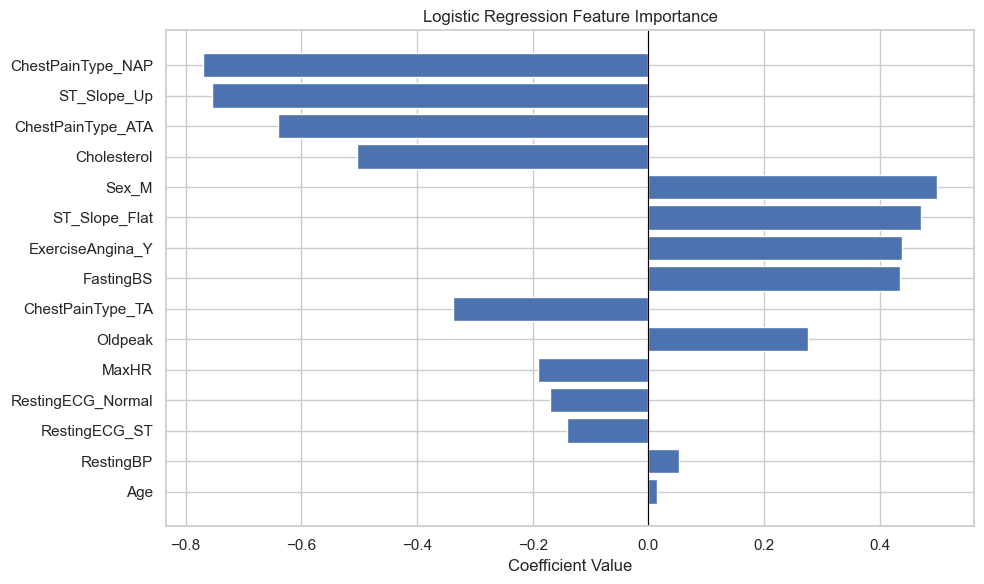

In [11]:
# Plot coefficient-based feature importance.
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importance")
plt.axvline(0, color="black", linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
coef_df["OddsRatio"] = np.exp(coef_df["Coefficient"])
coef_df[["Feature", "Coefficient", "OddsRatio"]].head(15)

,Feature,Coefficient,OddsRatio
8,ChestPainType_NAP,-0.769808,0.463102
14,ST_Slope_Up,-0.754459,0.470265
7,ChestPainType_ATA,-0.640135,0.527221
2,Cholesterol,-0.504210,0.603982
6,Sex_M,0.499464,1.647838
13,ST_Slope_Flat,0.472165,1.603463
12,ExerciseAngina_Y,0.439270,1.551574
3,FastingBS,0.435815,1.546223
9,ChestPainType_TA,-0.337129,0.713817
5,Oldpeak,0.275192,1.316784


In [13]:
# Use original df (before encoding) for age/sex analysis.
df_bins = df.copy()

age_min, age_max = df_bins["Age"].min(), df_bins["Age"].max()
bins = np.linspace(age_min, age_max, 11)   # 10 bins → 11 edges
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(10)]

df_bins["AgeBin"] = pd.cut(
    df_bins["Age"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

age_sex_summary = (
    df_bins
    .groupby(["Sex", "AgeBin"])["HeartDisease"]
    .agg(count="count", heart_disease_rate="mean")
    .reset_index()
)

age_sex_summary.head()

/var/folders/fb/63yxh46173qdwhx1wwh86wwh0000gn/T/ipykernel_57666/3620629411.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Sex", "AgeBin"])["HeartDisease"]


,Sex,AgeBin,count,heart_disease_rate
0,F,28-32,3,0.000000
1,F,32-37,10,0.100000
2,F,37-42,17,0.176471
3,F,42-47,26,0.115385
4,F,47-52,38,0.184211


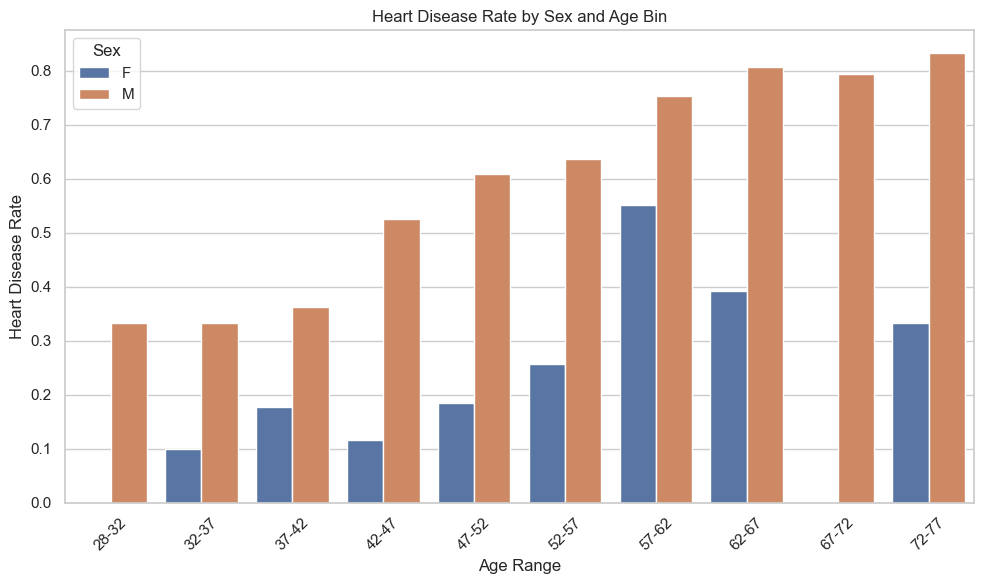

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=age_sex_summary,
    x="AgeBin",
    y="heart_disease_rate",
    hue="Sex"
)
plt.xticks(rotation=45)
plt.ylabel("Heart Disease Rate")
plt.xlabel("Age Range")
plt.title("Heart Disease Rate by Sex and Age Bin")
plt.tight_layout()
plt.show()

## Age–Sex Stratification (10 Age Bins)

To further explore demographic patterns, we stratified the dataset by sex and by 10 age bins and computed the heart disease rate in each group. Heart disease risk increases steadily with age for both males and females, and males consistently show higher rates of heart disease within the same age ranges.

This analysis is descriptive only (it is not used as a feature in the model), but it supports our fairness goal by checking whether the model is being trained on patterns that are clinically plausible rather than artifacts of the data.

## Overall Summary

The class-weighted logistic regression model performs well on the heart disease classification task, achieving strong accuracy and ROC–AUC while explicitly addressing class imbalance. The model’s feature importance and odds ratios highlight clinically meaningful predictors such as chest pain type, ST slope, cholesterol, sex, and exercise-induced angina. Age–sex stratification confirms that heart disease risk rises with age and is higher in males across age groups.

These results provide an interpretable baseline model that aligns with our project goal of combining predictive performance and fairness. In the full project report, we compare this balanced logistic regression with the team’s Decision Tree and Gradient Boosting models to evaluate trade-offs between accuracy, interpretability, and complexity.